## Melanoma Detection using a custom CNN in TensorFlow

## Table of Contents <a name="content0"/>
1. [Import necessary libraries & Set required parameters](#content1)
2. [Data Sourcing & Understanding](#content2)
3. [Dataset visualisation](#content3)
4. [Derived Metrics](#content4)
5. [Model Building & training](#content5)
<br/>    5.1 [Configure the dataset for performance](#content5_1)
<br/>    5.2 [Standardize the data & Create the model](#content5_2)
<br/>    5.3 [Compile the model](#content5_3)
<br/>    5.4 [Train the model](#content5_4)
<br/>    5.5 [Visualizing training results](#content5_5)

6. [Data Augmentation](#content6)
7. [Model Building & training on the augmented data](#content7)
<br/>    7.1 [Compile and train the model](#content7_1)
<br/>    7.2 [Visualize training results](#content7_2)
8. [Class distribution](#content8)
9. [Handling class imbalances](#content9)
10. [Model Building & training on the rectified class imbalance data](#content10)
<br/>    10.1 [Create the Model](#content10_1)
<br/>    10.2 [Compile the model](#content10_2)
<br/>    10.3 [Train the model](#content10_3)
<br/>    10.4 [Visualize the model results](#content10_4)
11. [Model Prediction for random test data](#content11)
12. [Conclusions](#content12)

## 1. Import necessary libraries & Set required parameters <a name="content1"/>

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

[Back To Top🔝](#content0)
## 2. Data Sourcing & Understanding<a name="content2"/>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip  /content/drive/MyDrive/Colab\ Notebooks/CNN_Assignment/CNN_assignment.zip

In [4]:
!ls "Skin cancer ISIC The International Skin Imaging Collaboration"

Test  Train


In [5]:
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


[Back To Top🔝](#content0)
## 3. Dataset Creation using a Keras utility<a name="content3"/>

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


[Back To Top🔝](#content0)
## 4. Dataset visualisation<a name="content4"/>

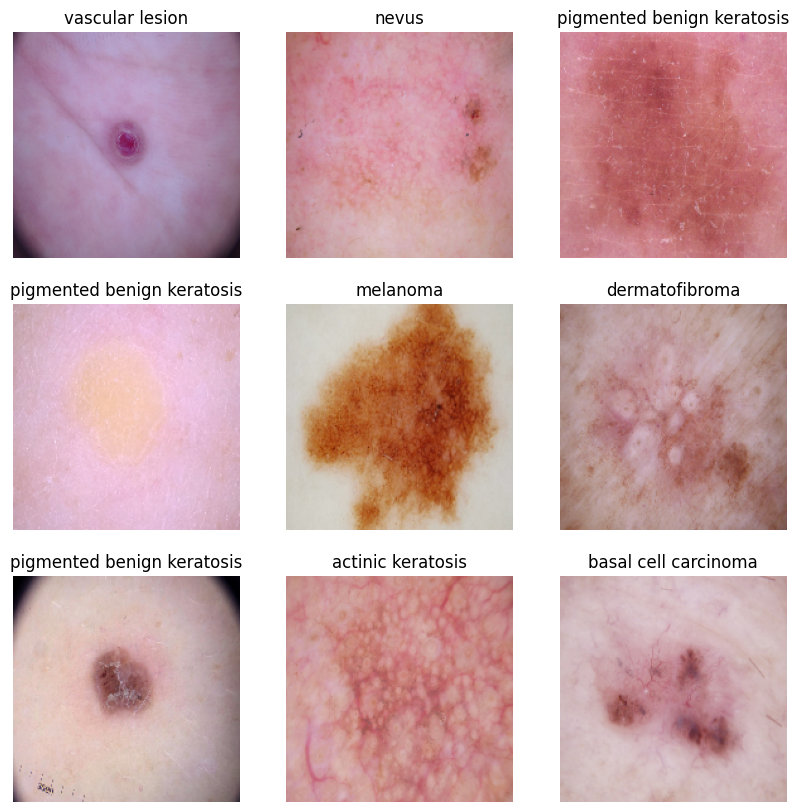

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

[Back To Top🔝](#content0)
## 5. Model Building & training<a name="content5"/>

### 5.1 Configure the dataset for performance<a name="content5_1"/>

We have to make sure to use buffered prefetching, so that we can yield data from disk without having I/O become blocking. These are two important methods we should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training our model. If our dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 5.2 Standardize the data & Create the model<a name="content5_2"/>

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general we should seek to make our input values small.

Here, we will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

[Back To Top🔝](#content0)
### 5.3 Compile the model<a name="content5_3"/>

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

[Back To Top🔝](#content0)
### 5.4 Train the model<a name="content5_4"/>

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 23s 68ms/step - loss: 2.1309 - accuracy: 0.2344 - val_loss: 1.8885 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8662 - accuracy: 0.3237 - val_loss: 1.8329 - val_accuracy: 0.3557
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.7306 - accuracy: 0.3705 - val_loss: 1.6329 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4764 - accuracy: 0.4883 - val_loss: 1.4430 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3221 - accuracy: 0.5324 - val_loss: 1.6724 - val_accuracy: 0.4072
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2807 - accuracy: 0.5391 - val_loss: 1.4399 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1892 - accuracy: 0.5776 - val_loss: 1.4094 - val_accuracy: 0.5481
Epoch 8/20
5

[Back To Top🔝](#content0)
### 5.5 Visualizing training results<a name="content5_5"/>
> Create plots of the loss and accuracy on the training and validation sets:

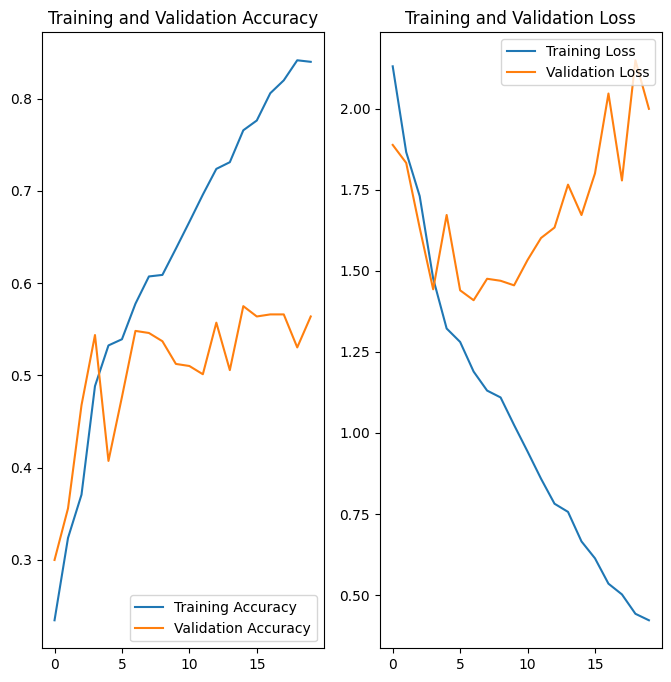

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<div class="observation" style='background-color:#DE3163;font-size:16px;padding:10px;color:white'>
    <p >Insights:<br/>We can clearly observe that traning accuracy is very high(83.9%) and validation accuracy is ver low(56.3%) thus confirming the overfitting</p>
    
**Tackling the overfitting problem**
1. **Data augumention** (from original datasource, collecting data through generative model)
2. Regularisation techniques(dropouts or normalisation techinques)
</div>

[Back To Top🔝](#content0)
## 6. Data Augumentation<a name="content6"/>

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

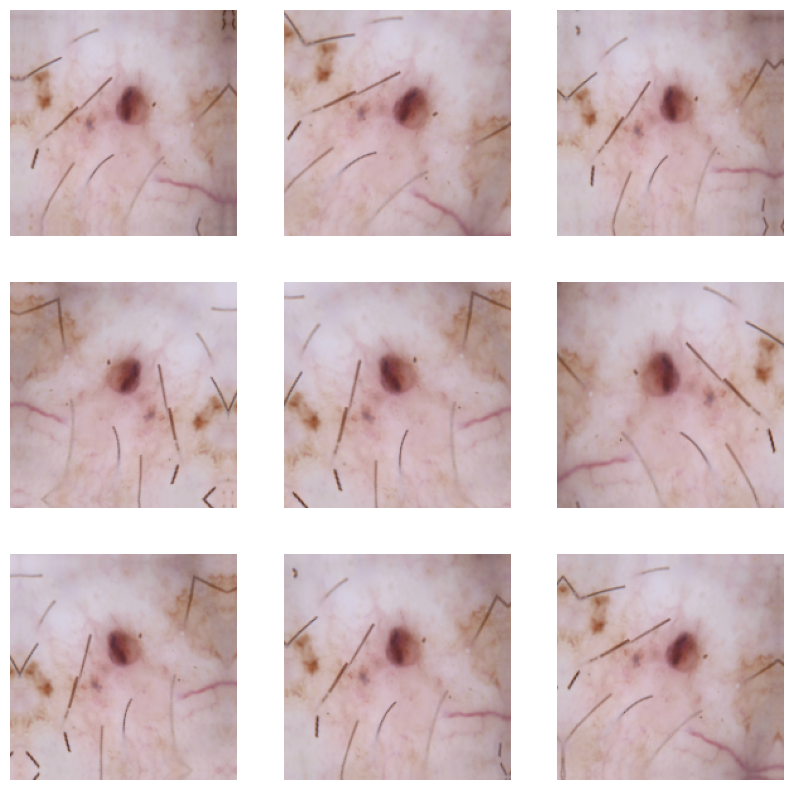

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    # ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(images[0].numpy().astype("uint8"))
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

We will add data augmentation to your model before training in the next step.

### Dropout

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

[Back To Top🔝](#content0)
## 7. Model Building & training on the augmented data<a name="content7"/>

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### 7.1 Compile and train the model<a name="content7_1"/>

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 32ms/step - loss: 2.0290 - accuracy: 0.2349 - val_loss: 1.8135 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.7003 - accuracy: 0.3878 - val_loss: 1.7814 - val_accuracy: 0.3870
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5404 - accuracy: 0.4609 - val_loss: 1.4843 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4337 - accuracy: 0.4944 - val_loss: 1.3744 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3838 - accuracy: 0.5106 - val_loss: 1.4050 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3334 - accuracy: 0.5279 - val_loss: 1.4037 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3247 - accuracy: 0.5385 - val_loss: 1.3983 - val_accuracy: 0.5123
Epoch 8/20
56

[Back To Top🔝](#content0)
### 7.2 Visualize training results<a name="content7_2"/>

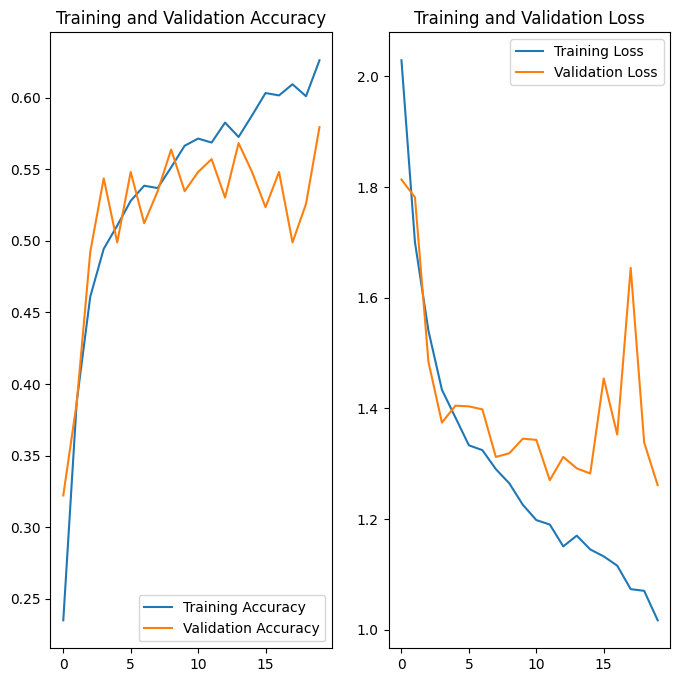

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<div class="observation" style='background-color:#DE3163;font-size:16px;padding:10px;color:white'>
    <p >Insights:<br/>We can clearly observe that traning accuracy is very low(62.6%) and validation accuracy is ver low(57.9%) thus confirming the underfitting</p>
    
**Tackling the underfitting problem**
1. **Handling class imbalances** (check and fixing the class imbalances fixes this issue)
</div>

[Back To Top🔝](#content0)
## 8. Class Distribution<a name="content8"/>

In [26]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [27]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

Path  \
0     Skin cancer ISIC The International Skin Imagin...   
1     Skin cancer ISIC The International Skin Imagin...   
2     Skin cancer ISIC The International Skin Imagin...   
3     Skin cancer ISIC The International Skin Imagin...   
4     Skin cancer ISIC The International Skin Imagin...   
...                                                 ...   
2234  Skin cancer ISIC The International Skin Imagin...   
2235  Skin cancer ISIC The International Skin Imagin...   
2236  Skin cancer ISIC The International Skin Imagin...   
2237  Skin cancer ISIC The International Skin Imagin...   
2238  Skin cancer ISIC The International Skin Imagin...   

                           Label  
0     pigmented benign keratosis  
1     pigmented benign keratosis  
2     pigmented benign keratosis  
3     pigmented benign keratosis  
4     pigmented benign keratosis  
...                          ...  
2234              dermatofibroma  
2235              dermatofibroma  
2236              dermatofibroma  
2237              dermatofibroma  
2238              dermatofibroma  

[2239 rows x 2 columns]

Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=1, n=376 (16.793%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=8, n=139 (6.208%)
Class=2, n=95 (4.243%)


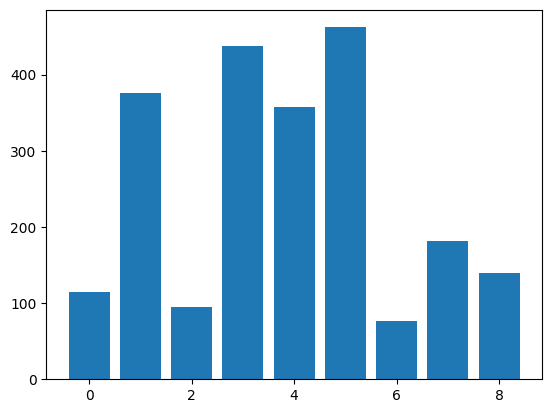

In [28]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

<div class="observation" style='background-color:#04AF70;font-size:16px;padding:10px;color:white'>
    <p >Insights:<br/>
        
1. We can clearly observe that there are very low samples for Class 0, Class 2, Class 6 & Class 8
2. We can see that Class 5 has highest number of samples in the data
3. We can observe that Class 1, Class 3, Class 4 & Class 5 are dominating other classes from the data

</div>



[Back To Top🔝](#content0)
## 9. Handling class imbalances<a name="content9"/>

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7894133A2200>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7894A005FDC0>: 100%|██████████| 500/500 [00:20<00:00, 23.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7894133A09D0>: 100%|██████████| 500/500 [00:22<00:00, 22.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78941329AB90>: 100%|██████████| 500/500 [01:29<00:00,  5.57 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7894130D7E80>: 100%|██████████| 500/500 [01:20<00:00,  6.20 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78945A999FF0>: 100%|██████████| 500/500 [00:15<00:00, 33.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7894C5C8B280>: 100%|██████████| 500/500 [00:39<00:00, 12.80 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7894A005FDC0>: 100%|██████████| 500/500 [00:15<00:00, 32.39 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78941332A3E0>: 100%|██████████| 500/500 [00:14<00:00, 34.02 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Distribution of augmented data after adding new images to the original training data.

In [32]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026280.jpg_6492a57d-99c7-4efc-bc51-bf175ec42f1b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027781.jpg_59bfe67e-31fe-45bb-9a57-06f92c6ba593.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025526.jpg_1bcb222b-9428-4e82-997f-43086cf1099b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026277.jpg_8413ab78-13be-462c-bd25-011daed1b28a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026835.jpg_e9fc6827-ba9c-4794-82bb-7802fa9db874.jpg',


In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-35-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

Class=5, n=962 (14.275%)
Class=6, n=577 (8.562%)
Class=0, n=614 (9.111%)
Class=7, n=681 (10.105%)
Class=1, n=876 (12.999%)
Class=3, n=938 (13.919%)
Class=4, n=857 (12.717%)
Class=8, n=639 (9.482%)
Class=2, n=595 (8.829%)


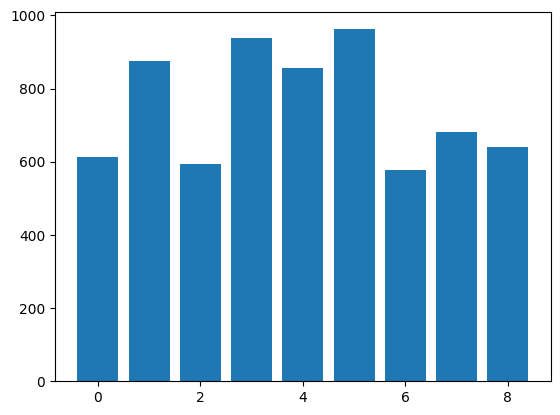

In [37]:
# split into input and output elements
X, y = new_df['Path'], new_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

[Back To Top🔝](#content0)
## 10. Model Building & training on the rectified class imbalance data<a name="content10"/>

In [38]:
batch_size = 32
img_height = 180
img_width = 180

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


[Back To Top🔝](#content0)
### 10.1 Create the Model<a name="content10_1"/>

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 10.2 Compile the Model<a name="content10_2"/>

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

[Back To Top🔝](#content0)
### 10.3 Train the Model<a name="content10_3"/>

In [43]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 32s 59ms/step - loss: 2.0638 - accuracy: 0.2277 - val_loss: 1.9707 - val_accuracy: 0.2821
Epoch 2/30
169/169 [==============================] - 5s 28ms/step - loss: 1.5876 - accuracy: 0.3960 - val_loss: 1.6233 - val_accuracy: 0.3935
Epoch 3/30
169/169 [==============================] - 5s 29ms/step - loss: 1.3727 - accuracy: 0.4824 - val_loss: 1.2986 - val_accuracy: 0.5167
Epoch 4/30
169/169 [==============================] - 5s 28ms/step - loss: 1.1891 - accuracy: 0.5606 - val_loss: 1.2414 - val_accuracy: 0.5568
Epoch 5/30
169/169 [==============================] - 5s 28ms/step - loss: 1.0836 - accuracy: 0.5948 - val_loss: 1.1005 - val_accuracy: 0.6013
Epoch 6/30
169/169 [==============================] - 5s 29ms/step - loss: 0.9764 - accuracy: 0.6374 - val_loss: 0.9632 - val_accuracy: 0.6682
Epoch 7/30
169/169 [==============================] - 5s 28ms/step - loss: 0.8620 - accuracy: 0.6877 - val_loss: 0.9821 - val_accuracy: 0.646

[Back To Top🔝](#content0)
### 10.4 Visualize the model results<a name="content10_4"/>

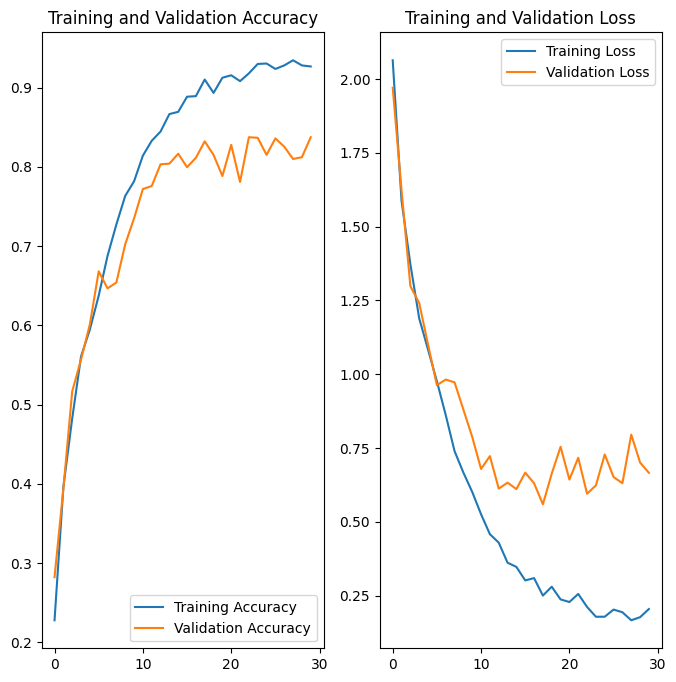

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<div class="observation" style='background-color:#04AF70;font-size:16px;padding:10px;color:white'>
    <p >Insights:<br/> We can clearly observe that our model now has a good acuracy of 92.6% with validation accuracy of 83.7%. Therefore, we can proceed with this model
</div>

[Back To Top🔝](#content0)
## 11. Model Prediction for random test data<a name="content11"/>

In [56]:

test_ds = tf.keras.utils.image_dataset_from_directory(
           data_dir_test,
           shuffle=True,
           image_size=(img_height, img_width),
           batch_size=batch_size
           )
# predictions = model.predict(test_ds)
# score = tf.nn.softmax(predictions)

Found 118 files belonging to 9 classes.


1/1 [==============================] - 0s 31ms/step


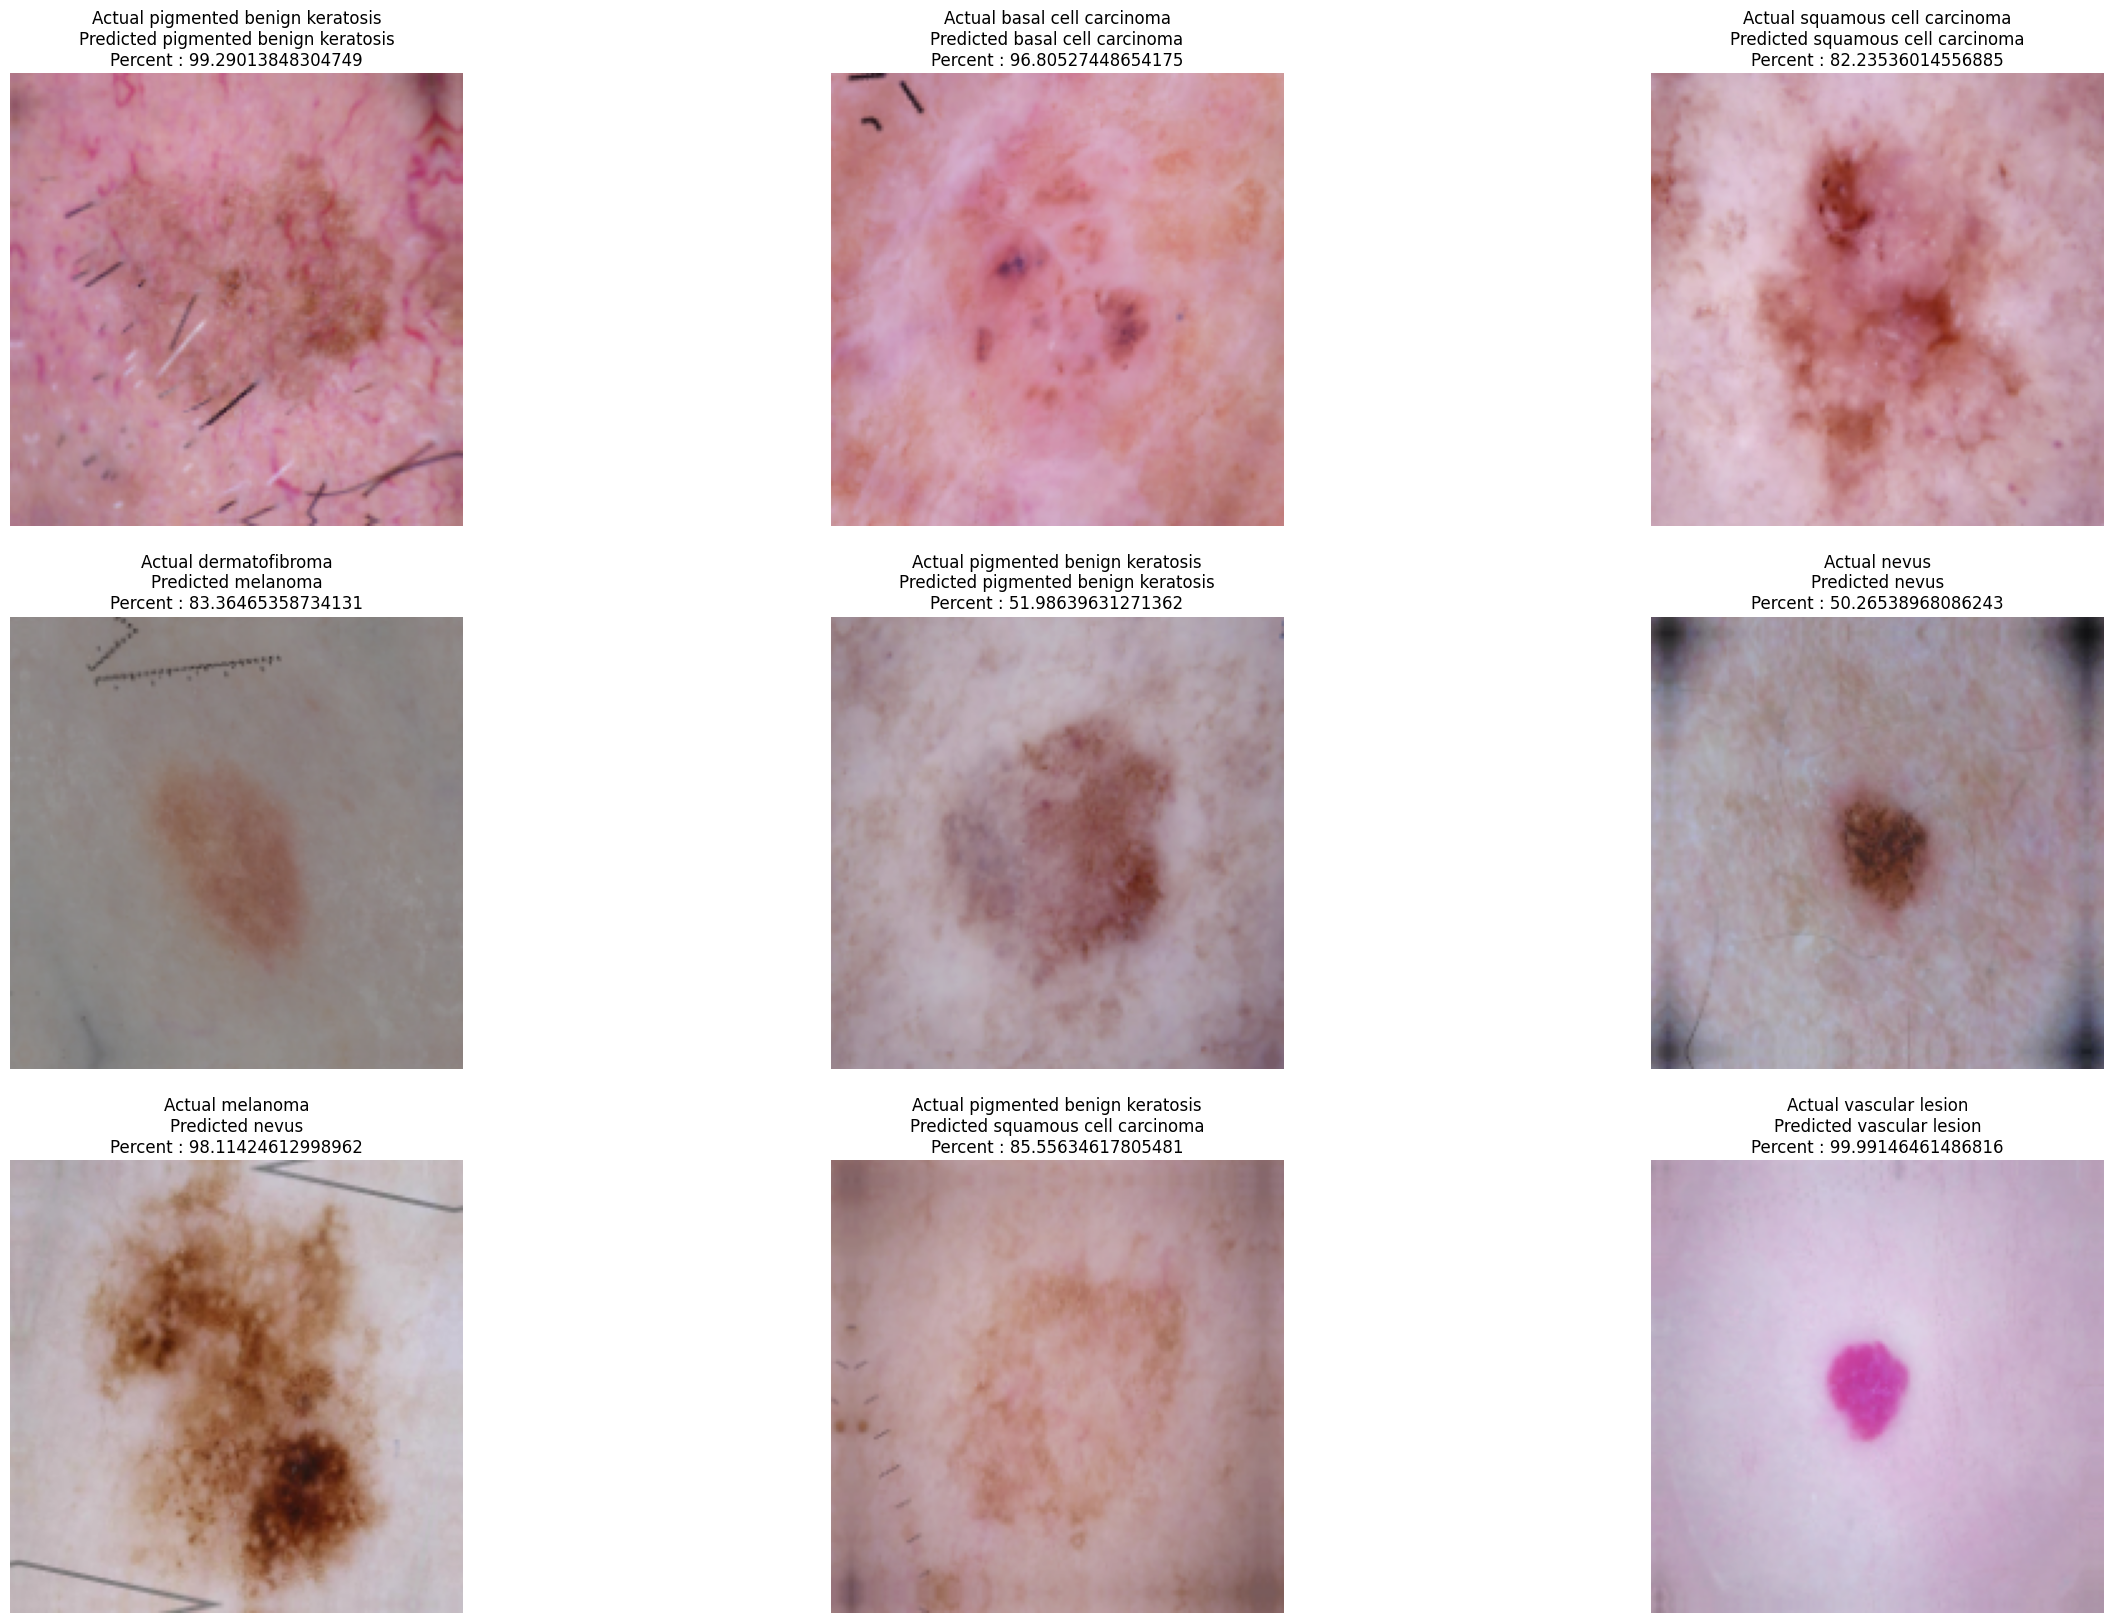

In [57]:
plt.figure(figsize=(30, 20))
for images, labels in test_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
      ax = plt.subplot(3, 3, (i + 1))
      img = augmented_images[i]
      img_array = tf.keras.utils.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)
      predictions = model.predict(img_array)
      score = tf.nn.softmax(predictions[0])
      title = "Actual "+str(class_names[labels[i]])+"\n"+"Predicted "+str(class_names[np.argmax(score)])+"\n"+"Percent : "+str(100 * np.max(score))
      plt.title(title)
      plt.imshow(augmented_images[i].numpy().astype("uint8"))
      plt.axis("off")


[Back To Top🔝](#content0)
## 12. Conclusions<a name="content12"/>

<div class="observation" style='background-color:#6495ED;font-size:16px;padding:10px;color:white'>
    We created a custom CNN based model with decent accuracy to detect <b>melanoma</b> and formed the below conclusions<br/>
        <br>1. We have created 3 models and have seen improvement from first model to 3rd model by adding data agumentation & handling class imbalances.
        <br>2. We attained the 3rd model with 92.6% accuracy on train dataset and 83.7% accuracy on validation dataset.
        <br>3. With the right hyper-parameter tuning, accuracy can still be improved even more. We can experiment with different CNN configurations, regularisation techniques, loss functions, optimizers, and layer/epoch counts to see accuracy pattern.
</div>